[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Mannheim_Multihalle.ipynb)

In [ ]:
!pip install JaxSSO
!pip install nlopt

In [1]:
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
import JaxSSO.optimization as optimization
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import json

/tmp/ipykernel_2290440/3059525336.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#Import the geometry, mesh and fixed node info
f = open('Station.json')
 
# returns JSON object as 
# a dictionary
data = json.load(f)


f.close()

df = data['faces'] #Connectivity matrix
faces = np.array(df) #convert to numpy array
df2 = data['vertices'] #Coordinate
crd = np.array(df2) #convert to numpy array
df3 = data['vertex_is_red'] #Connectivity matrix
fixed_nodes = np.where(df3)[0] #convert to numpy array

#From faces to frames
import trimesh
mesh = trimesh.load('Station.ply')

cnct  = np.array(mesh.edges_unique)

In [3]:
#Normalize the coordinates
x_nodes = crd[:,0]-min(crd[:,0])
y_nodes = crd[:,1]-min(crd[:,1])
z_nodes = crd[:,2]

n_node = crd.shape[0] #number of nodes
n_ele = cnct.shape[0] #number of elements

In [4]:
design_nodes = [] 
for i in range(n_node):
    
    if i not in fixed_nodes:
        design_nodes.append(i)

fixed_nodes = np.array(fixed_nodes,dtype=int)
design_nodes = np.array(design_nodes,dtype=int)
non_design_nodes = fixed_nodes
x_ele = np.zeros((n_ele,2))
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
  x_ele[i,0] = x_nodes[cnct[i,0]]
  x_ele[i,1] = x_nodes[cnct[i,1]]
  y_ele[i,0] = y_nodes[cnct[i,0]]
  y_ele[i,1] = y_nodes[cnct[i,1]]
  z_ele[i,0] = z_nodes[cnct[i,0]]
  z_ele[i,1] = z_nodes[cnct[i,1]]

design_crds = np.expand_dims(design_nodes,axis=1)
design_crds = np.hstack((design_crds,2*np.ones((design_crds.shape[0],1),dtype=int)))

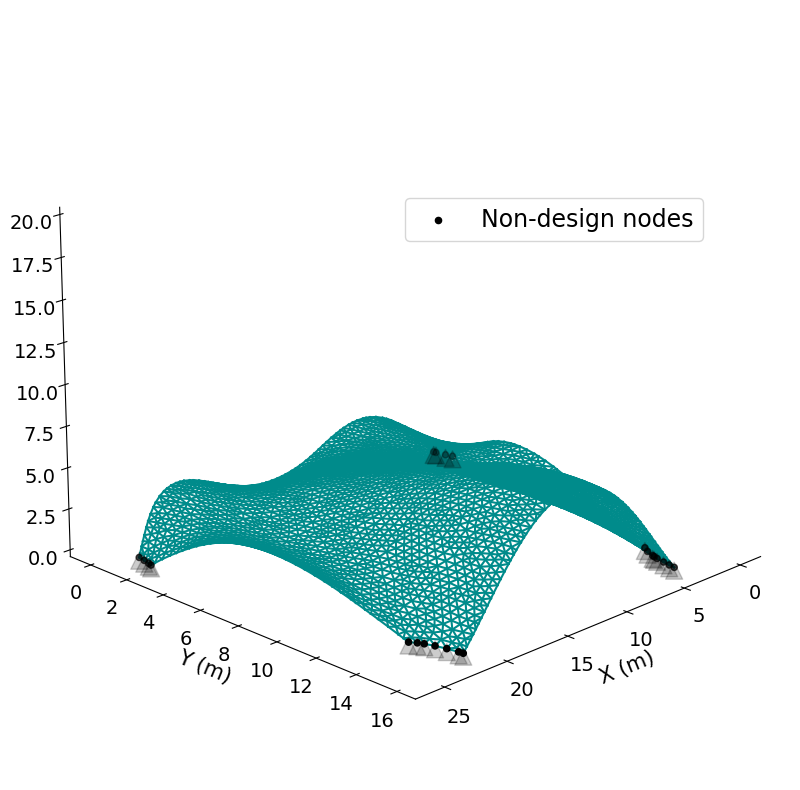

In [5]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,20)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, 45)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

In [6]:
# Inputs of NN
# Embed some info
# 1. X,Y COORDINATES
# 2. Distance to the boundary: how close they are to the boundary
# 3. Centrality
from jax import vmap
def dis_boundary(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the minimum distance of each node to the boundary node
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    return jnp.min(vmap_norm(crd_xy,bound_xy),axis=1)

def v_centrality(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the vertex centrality. Normalized so that maximum is "1".
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    
    return jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1)/jnp.max(jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1))

In [7]:
dis_b = dis_boundary(x_nodes,y_nodes,non_design_nodes)[design_nodes]
v_cen = v_centrality(x_nodes,y_nodes,non_design_nodes)[design_nodes]

In [8]:
################
#  SSO MODEL   #
################
#Build the model
#Sectional properties-> 600x400 rectangle
h = 0.2 #height
b = 0.1 #width
E = 37900 * 10**5 #Young's modulus (pa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
Iy = b*h**3/12 #Moement of inertia in m^4
Iz = h*b**3/12 #Same, about z axis
J = Iy + Iz	#Polar moment of inertia
A = b*h #Area
load = -10 #Pt load

model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):

    model.add_node(i,x_nodes[i],y_nodes[i],z_nodes[i])
    if i in fixed_nodes:
        model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-load,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    model.add_beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) 


In [9]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

In [10]:
%timeit sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)

1.22 s ± 6.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
import pymesh
from flax import linen as nn

In [12]:
class SimpleNN(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons
    num_layers: int #Number of hidden layers

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        for i in range(self.num_layers):
            x = nn.Dense(features=self.num_hidden)(x)
            x = nn.leaky_relu(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x

In [13]:
n_input = 3 #(X,Y,dis_b,v_centrality) of each node
n_hidden = 500 # neurons
n_out = 1 #Z of each node
n_layers =3 #number of hidden layers

rng = jax.random.PRNGKey(42)

inp = np.array([x_nodes[design_nodes],y_nodes[design_nodes],dis_b]).T
#rng, inp_rng, init_rng = jax.random.split(rng, 3)

In [14]:
NN = SimpleNN(n_hidden,n_out,n_layers)

In [15]:
import jax
import jax.numpy as jnp  # JAX NumPy


print(NN.tabulate(rng,inp,
                   compute_flops=True, compute_vjp_flops=True))


                                SimpleNN Summary                                
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┓
┃ path    ┃ module   ┃ inputs    ┃ outputs  ┃ flops     ┃ vjp_flo… ┃ params    ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━┩
│         │ SimpleNN │ float64[… │ float64… │ 28345664… │ 8495275… │           │
├─────────┼──────────┼───────────┼──────────┼───────────┼──────────┼───────────┤
│ Dense_0 │ Dense    │ float64[… │ float64… │ 9823000   │ 28065500 │ bias:     │
│         │          │           │          │           │          │ float32[… │
│         │          │           │          │           │          │ kernel:   │
│         │          │           │          │           │          │ float32[… │
│         │          │           │          │           │          │           │
│         │          │           │          │           │          │ 2,000     │
│         │          │     

In [16]:
rng, init_rng = jax.random.split(rng, 2)
# Initialize the model
params = NN.init(init_rng, inp)

In [17]:
NN.apply(params,inp).reshape(-1).shape

(2806,)

In [18]:
import optax
optimizer = optax.adamw(learning_rate=0.0001,weight_decay=1e-4)

In [19]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=NN.apply,
                                            params=params,
                                            tx=optimizer)

In [20]:
def calculate_loss(state, params, inp):
    
    ##Apply_fn: ML input to output
    z_new = state.apply_fn(params, inp).reshape(-1) #Z-coordinate, ML-Output
    
    #ML output to loss through Jax-SSO
    sso_model.update_nodeparameter(z_new)
    loss = sso_model.params_to_objective()
     
    return loss#+jnp.norm(z_new)

In [21]:
@jax.jit  # Jit the function for efficiency
def train_step(state, inp):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, inp)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [22]:
%timeit train_step(model_state, inp)

1.21 s ± 5.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
metrics_history = {'train_loss': []}
from tqdm import tqdm
def train_model(state, num_epochs=2000):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        state, loss = train_step(state, inp)
        metrics_history['train_loss'].append(loss)
        print('Train epoch {}'.format(len(metrics_history['train_loss'])+1)+'  ,loss:{}'.format(loss))
        # We could use the loss and accuracy for logging here, e.g. in TensorBoard
        # For simplicity, we skip this part here
    return state

In [24]:
trained_model_state = train_model(model_state, num_epochs=50)

  2%|▏         | 1/50 [00:01<00:59,  1.22s/it]

Train epoch 2  ,loss:860.2849951317432


  4%|▍         | 2/50 [00:02<00:58,  1.22s/it]

Train epoch 3  ,loss:445.1984584323111


  6%|▌         | 3/50 [00:03<00:57,  1.23s/it]

Train epoch 4  ,loss:214.23291267644038


  8%|▊         | 4/50 [00:04<00:56,  1.23s/it]

Train epoch 5  ,loss:172.296346529024


 10%|█         | 5/50 [00:06<00:55,  1.23s/it]

Train epoch 6  ,loss:155.75640218239366


 12%|█▏        | 6/50 [00:07<00:54,  1.24s/it]

Train epoch 7  ,loss:139.59375556354945


 14%|█▍        | 7/50 [00:08<00:53,  1.24s/it]

Train epoch 8  ,loss:123.1947548366449


 16%|█▌        | 8/50 [00:09<00:51,  1.23s/it]

Train epoch 9  ,loss:109.58588983569436


 18%|█▊        | 9/50 [00:11<00:50,  1.23s/it]

Train epoch 10  ,loss:99.68764460024536


 20%|██        | 10/50 [00:12<00:49,  1.23s/it]

Train epoch 11  ,loss:92.77030007322722


 22%|██▏       | 11/50 [00:13<00:48,  1.23s/it]

Train epoch 12  ,loss:87.64967129867858


 24%|██▍       | 12/50 [00:14<00:46,  1.23s/it]

Train epoch 13  ,loss:83.98726239773283


 26%|██▌       | 13/50 [00:16<00:45,  1.23s/it]

Train epoch 14  ,loss:81.06165413820477


 28%|██▊       | 14/50 [00:17<00:44,  1.23s/it]

Train epoch 15  ,loss:78.35485963087832


 30%|███       | 15/50 [00:18<00:43,  1.23s/it]

Train epoch 16  ,loss:75.61893036439469


 32%|███▏      | 16/50 [00:19<00:42,  1.24s/it]

Train epoch 17  ,loss:72.85380072577415


 34%|███▍      | 17/50 [00:20<00:40,  1.24s/it]

Train epoch 18  ,loss:70.11855401574071


 36%|███▌      | 18/50 [00:22<00:39,  1.24s/it]

Train epoch 19  ,loss:67.52376405768888


 38%|███▊      | 19/50 [00:23<00:38,  1.24s/it]

Train epoch 20  ,loss:65.01583940168291


 40%|████      | 20/50 [00:24<00:37,  1.24s/it]

Train epoch 21  ,loss:62.57115214416952


 42%|████▏     | 21/50 [00:25<00:35,  1.24s/it]

Train epoch 22  ,loss:60.21231326272978


 44%|████▍     | 22/50 [00:27<00:34,  1.24s/it]

Train epoch 23  ,loss:57.861533210976596


 46%|████▌     | 23/50 [00:28<00:33,  1.24s/it]

Train epoch 24  ,loss:55.32041647054653


 48%|████▊     | 24/50 [00:29<00:32,  1.24s/it]

Train epoch 25  ,loss:52.257262321417436


 50%|█████     | 25/50 [00:30<00:30,  1.24s/it]

Train epoch 26  ,loss:48.266720059410446


 52%|█████▏    | 26/50 [00:32<00:29,  1.24s/it]

Train epoch 27  ,loss:42.779982519632725


 54%|█████▍    | 27/50 [00:33<00:28,  1.24s/it]

Train epoch 28  ,loss:36.33591850278673


 56%|█████▌    | 28/50 [00:34<00:27,  1.24s/it]

Train epoch 29  ,loss:33.37973925278747


 58%|█████▊    | 29/50 [00:35<00:26,  1.24s/it]

Train epoch 30  ,loss:41.46453577527244


 60%|██████    | 30/50 [00:37<00:24,  1.24s/it]

Train epoch 31  ,loss:43.15421188850277


 62%|██████▏   | 31/50 [00:38<00:23,  1.24s/it]

Train epoch 32  ,loss:37.084675113424446


 64%|██████▍   | 32/50 [00:39<00:22,  1.24s/it]

Train epoch 33  ,loss:30.50108812363789


 66%|██████▌   | 33/50 [00:40<00:21,  1.24s/it]

Train epoch 34  ,loss:31.588985663684774


 68%|██████▊   | 34/50 [00:42<00:19,  1.24s/it]

Train epoch 35  ,loss:33.77240513179922


 70%|███████   | 35/50 [00:43<00:18,  1.24s/it]

Train epoch 36  ,loss:35.05696028626653


 72%|███████▏  | 36/50 [00:44<00:17,  1.24s/it]

Train epoch 37  ,loss:34.366174334431726


 74%|███████▍  | 37/50 [00:45<00:16,  1.24s/it]

Train epoch 38  ,loss:31.85914718006861


 76%|███████▌  | 38/50 [00:46<00:14,  1.23s/it]

Train epoch 39  ,loss:28.934067233224273


 78%|███████▊  | 39/50 [00:48<00:13,  1.24s/it]

Train epoch 40  ,loss:26.954357523211513


 80%|████████  | 40/50 [00:49<00:12,  1.24s/it]

Train epoch 41  ,loss:27.37229908113504


 82%|████████▏ | 41/50 [00:50<00:11,  1.24s/it]

Train epoch 42  ,loss:29.715797222239583


 84%|████████▍ | 42/50 [00:51<00:09,  1.24s/it]

Train epoch 43  ,loss:27.764978606574786


 86%|████████▌ | 43/50 [00:53<00:08,  1.24s/it]

Train epoch 44  ,loss:25.653492323926884


 88%|████████▊ | 44/50 [00:54<00:07,  1.25s/it]

Train epoch 45  ,loss:25.7754140069977


 90%|█████████ | 45/50 [00:55<00:06,  1.24s/it]

Train epoch 46  ,loss:26.579442112563015


 92%|█████████▏| 46/50 [00:56<00:04,  1.24s/it]

Train epoch 47  ,loss:26.8873507363144


 94%|█████████▍| 47/50 [00:58<00:03,  1.24s/it]

Train epoch 48  ,loss:26.404544178955


 96%|█████████▌| 48/50 [00:59<00:02,  1.23s/it]

Train epoch 49  ,loss:25.281505842366684


 98%|█████████▊| 49/50 [01:00<00:01,  1.24s/it]

Train epoch 50  ,loss:24.05463478024354


100%|██████████| 50/50 [01:01<00:00,  1.24s/it]

Train epoch 51  ,loss:23.929179270637274


In [25]:
##Apply_fn: ML input to output
z_new = trained_model_state.apply_fn(trained_model_state.params, inp).reshape(-1) #how to move nodes along z, ML-Outpu

#ML output to loss through Jax-SSO
z_nodes[design_nodes] = (z_new-np.min(z_new))

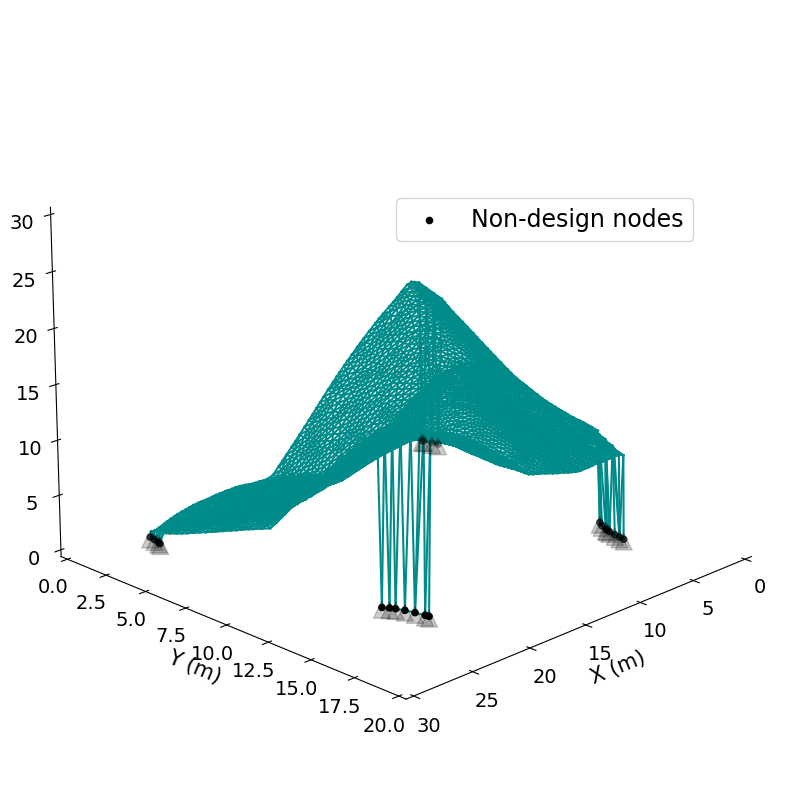

In [26]:
#Update the nodes
%matplotlib inline
z_ele[:,0] = z_nodes[cnct[:,0]]
z_ele[:,1] = z_nodes[cnct[:,1]]


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,30)
ax.set_xlim(0,30)
ax.set_ylim(0,20)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, 45)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()